# Impact of 3.2 Beer in Minnesota

In [15]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### Load Data

In [16]:
#Stores Data
Stores = pd.read_csv('MinnesotaStoreDataV1.csv')
#Stores Classification data
StoresClass = pd.read_csv('NonLowPointStoresMinnesotaV1.csv', dtype = str)

In [17]:
Stores.head()

,STORE_CD,L12M_TY_QTY,PREMISE_TYPE_DSC,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,BEER_FLG,...,MALE_POP_5564_PCT,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT
0,202196323,17.0000,ON PREMISE,RECREATION,THEATER,AMERICAN,LOWEST 20% ON/ LOWEST 20% OFF,Y,N,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,103793493,397.8332,ON PREMISE,DINING,CASUAL DINING,MEXICAN,MID 30% ON/ MID 60% OFF,N,N,Y,...,0.0581,0.0354,0.0216,0.0201,0.1052,0.0728,0.0595,0.0599,0.0413,0.0334
2,105645970,NaN,ON PREMISE,DINING,FINE DINING,ITALIAN,LOWEST 20% ON/ LOWEST 20% OFF,N,N,Y,...,0.0584,0.0364,0.0228,0.0192,0.0942,0.0728,0.0617,0.0621,0.0436,0.0365
3,103779046,0.0000,OFF PREMISE,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,N,N,Y,...,0.0483,0.0305,0.0135,0.0589,0.1088,0.0667,0.0420,0.0450,0.0310,0.0185
4,105646503,13.0000,ON PREMISE,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,OTHER,TOP 50% ON/ TOP 20% OFF,N,N,Y,...,0.0658,0.0376,0.0240,0.0230,0.0546,0.0669,0.0703,0.0619,0.0402,0.0338


#### Clean Data

In [18]:

#Remove Stores without Depletion data for the last year (NAs)
Stores = Stores.loc[Stores['L12M_TY_QTY'].notnull(),:]
print('Stores after removing stores with no depletion data ',len(Stores))

#Remove Stores with Negative Depletion data for the last year
Stores = Stores.loc[Stores['L12M_TY_QTY'] > 0,:] 
print('Stores after removing stores with negative ',len(Stores))

#Remove Stores without Demographic data (NAs)
Stores = Stores.loc[Stores['MALE_POP_5564_PCT'].notnull(),:]
print('Stores after removing stores with no demographic data ',len(Stores))

Stores = Stores.reset_index(drop=True)

#Change Y and N to 1 and 0
Stores['CHAIN_IND_FLG'] = Stores['CHAIN_IND_FLG']=='Y'
Stores['FRANCHISE_FLG'] = Stores['FRANCHISE_FLG']=='Y'
Stores['BEER_FLG'] = Stores['BEER_FLG']=='Y'
Stores['WINE_FLG'] = Stores['WINE_FLG']=='Y'
Stores['LIQUOR_FLG'] = Stores['LIQUOR_FLG']=='Y'
Stores['FINE_WINE_FLG'] = Stores['FINE_WINE_FLG']=='Y'

Stores['STORE_CD'] = Stores['STORE_CD'].astype(str)

Stores after removing stores with no depletion data  6931
Stores after removing stores with negative  6303
Stores after removing stores with no demographic data  5400


In [19]:
#Divide stores data into ON PREMISE and OFF PREMISE

StoresON = Stores[Stores.PREMISE_TYPE_DSC == 'ON PREMISE'].reset_index(drop=True)
StoresOFF = Stores[Stores.PREMISE_TYPE_DSC == 'OFF PREMISE'].reset_index(drop=True)


## ON PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [20]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [21]:
len(StoresON.columns)

43

In [23]:
for col in StoresON.columns:
    print(StoresON[col].describe())
    print("")

count          3465
unique         3465
top       102907577
freq              1
Name: STORE_CD, dtype: object

count    3465.000000
mean       74.289954
std       220.638652
min         0.583300
25%         9.000000
50%        22.000000
75%        53.888900
max      5758.111900
Name: L12M_TY_QTY, dtype: float64

count           3465
unique             1
top       ON PREMISE
freq            3465
Name: PREMISE_TYPE_DSC, dtype: object

count       3465
unique         5
top       DINING
freq        1707
Name: CHANNEL_DSC, dtype: object

count              3465
unique               20
top       CASUAL DINING
freq               1455
Name: SUBCHANNEL_DSC, dtype: object

count      3465
unique       11
top       OTHER
freq       1398
Name: FOOD_TYPE_GROUP_DSC, dtype: object

count                              3465
unique                                3
top       LOWEST 20% ON/ LOWEST 20% OFF
freq                               1980
Name: INDUSTRY_VOL_DSC, dtype: object

count      3465
unique 

In [24]:
#Remove Not Necessary Columns
del StoresON['PREMISE_TYPE_DSC'] #Unique
del StoresON['BEER_FLG'] # No Variance
del StoresON['FINE_WINE_FLG'] # No Variance


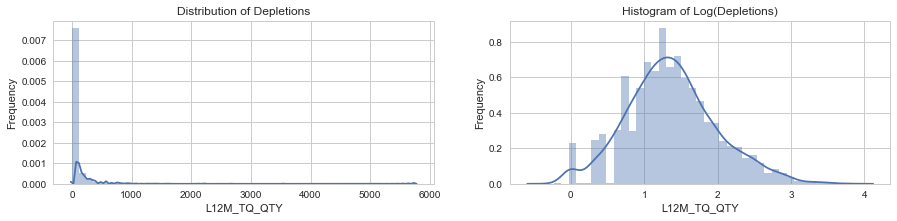

In [25]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresON['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresON['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [26]:
#Binarize function
def binarize(dataframe , column):
    dataframe = pd.concat([dataframe ,pd.get_dummies(dataframe[column] , prefix = ['B_'+c for c in column])] , axis = 1)
    return(dataframe)

In [27]:
StoresON.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC',
       'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC', 'CHAIN_IND_FLG',
       'FRANCHISE_FLG', 'WINE_FLG', 'LIQUOR_FLG', 'WHITE_POP_PCT',
       'BLACK_POP_PCT', 'ASIAN_POP_PCT', 'HISP_POP_PCT',
       'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [28]:
#Get Dummies
DummiesColumnsON = ['CHANNEL_DSC','SUBCHANNEL_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC']
StoresC_ON = binarize(StoresON, DummiesColumnsON)

#Normalize Depletions using Min-Max method
scaler = MinMaxScaler() 
StoresC_ON['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresON['L12M_TY_QTY'].values.reshape(-1,1)) 


In [29]:
# prepare data to fit model
X_labels_ON = [c for c in StoresC_ON.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','FOOD_TYPE_GROUP_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_ON = StoresC_ON.loc[:,X_labels_ON]

In [30]:
X_ON.head()

,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,...,B_FOOD_TYPE_GROUP_DSC_OTHER,B_FOOD_TYPE_GROUP_DSC_PIZZA,B_FOOD_TYPE_GROUP_DSC_SEAFOOD,B_FOOD_TYPE_GROUP_DSC_SMALL FOOD,B_FOOD_TYPE_GROUP_DSC_STEAK,B_FOOD_TYPE_GROUP_DSC_VARIED MENU,B_INDUSTRY_VOL_DSC_LOWEST 20% ON/ LOWEST 20% OFF,B_INDUSTRY_VOL_DSC_MID 30% ON/ MID 60% OFF,B_INDUSTRY_VOL_DSC_TOP 50% ON/ TOP 20% OFF,NORM_L12M_TY_QTY
0,False,False,True,True,0.7596,0.1108,0.0554,0.0474,0.0118,0.0172,...,0,0,0,0,0,0,0,1,0,0.068997
1,False,False,True,True,0.9312,0.0072,0.0114,0.0421,0.0087,0.0138,...,1,0,0,0,0,0,0,0,1,0.002157
2,False,False,True,True,0.7775,0.0035,0.0019,0.0119,0.0026,0.0038,...,0,0,0,0,0,1,1,0,0,0.000941
3,False,False,True,True,0.9530,0.0062,0.0091,0.0240,0.0057,0.0077,...,0,0,0,0,0,0,1,0,0,0.057355
4,False,False,True,True,0.9072,0.0204,0.0270,0.0363,0.0076,0.0120,...,1,0,0,0,0,0,0,0,1,0.004762


### Clustering

#### Choose number of Clusters

In [33]:
#Silhouette_score
results = []
NumberClusters = range(2,12,1)
for k in NumberClusters:
    kmeans_model = cluster.KMeans(n_clusters=k, random_state=1, n_jobs = -2).fit(X_ON)
    labels = kmeans_model.labels_
    score = metrics.silhouette_score(X_ON, labels, metric='euclidean')
    results.append((k,score))

Clustering_Score = pd.DataFrame(data=results,columns=['NumberOfClusters','silhouette_score'])
Clustering_Score

,NumberOfClusters,silhouette_score
0,2,0.325437
1,3,0.340879
2,4,0.297265
3,5,0.274718
4,6,0.325093
5,7,0.314703
6,8,0.320982
7,9,0.360098
8,10,0.348289
9,11,0.360150


In [49]:
#Cluster the Data ON
kmeans_model = cluster.KMeans(n_clusters=3, random_state=1, n_jobs = -2).fit(X_ON)
labels = kmeans_model.labels_

In [50]:
#Assign Cluster to Data
StoresON['CLUSTER'] = labels

In [51]:
StoresON.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER
0,103793493,397.8332,DINING,CASUAL DINING,MEXICAN,MID 30% ON/ MID 60% OFF,False,False,True,True,...,0.0354,0.0216,0.0201,0.1052,0.0728,0.0595,0.0599,0.0413,0.0334,2
1,105646503,13.0000,BAR/NIGHTCLUB,CASUAL NIGHTCLUB,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0376,0.0240,0.0230,0.0546,0.0669,0.0703,0.0619,0.0402,0.0338,0
2,105645328,6.0000,DINING,CASUAL DINING,VARIED MENU,LOWEST 20% ON/ LOWEST 20% OFF,False,False,True,True,...,0.1062,0.0501,0.0184,0.0411,0.0345,0.0530,0.0845,0.1039,0.0463,2
3,202252793,330.8054,DINING,CASUAL DINING,MEXICAN,LOWEST 20% ON/ LOWEST 20% OFF,False,False,True,True,...,0.0455,0.0313,0.0239,0.0597,0.0594,0.0636,0.0676,0.0530,0.0532,2
4,105649082,28.0000,LODGING,FULL SERVICE LODGING,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0456,0.0330,0.0229,0.0584,0.0588,0.0626,0.0695,0.0491,0.0463,1


### Regression Analysis

In [52]:
#Merge Class with StoreON Data for regression
RegressionDataON = pd.merge(StoresON, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionDataON.loc[RegressionDataON['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [53]:
RegressionDataON.tail()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,FOOD_TYPE_GROUP_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,...,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER,RTL_STORE_CD,BEERTYPE
3460,105645016,28.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,AMERICAN,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0247,0.0533,0.0692,0.0792,0.0621,0.0352,0.0193,0,105645016,NonLowPoint
3461,105646544,32.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,MID 30% ON/ MID 60% OFF,False,False,True,True,...,0.0229,0.0561,0.0761,0.0764,0.0551,0.0313,0.0175,0,105646544,NonLowPoint
3462,105646682,8.0,BAR/NIGHTCLUB,COUNTRY WESTERN,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,False,False,True,True,...,0.0232,0.0718,0.0686,0.0699,0.0671,0.0418,0.0278,0,105646682,NonLowPoint
3463,105646574,9.0,BAR/NIGHTCLUB,COUNTRY WESTERN,OTHER,LOWEST 20% ON/ LOWEST 20% OFF,False,False,True,True,...,0.0232,0.0596,0.0693,0.0757,0.0665,0.0395,0.0255,0,105646574,NonLowPoint
3464,105646371,514.0,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,OTHER,TOP 50% ON/ TOP 20% OFF,False,False,True,True,...,0.0204,0.0665,0.0865,0.0724,0.0490,0.0267,0.0162,0,105646371,NonLowPoint


In [54]:
len(RegressionDataON)

3465

### Regression controlling for Cluster

In [55]:
#Regression ON Premise
modON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE) + C(CLUSTER)', data=RegressionDataON)
print(modON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.030
Model:                             OLS   Adj. R-squared:                  0.030
Method:                  Least Squares   F-statistic:                     36.27
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           4.50e-23
Time:                         15:30:16   Log-Likelihood:                -6067.4
No. Observations:                 3465   AIC:                         1.214e+04
Df Residuals:                     3461   BIC:                         1.217e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

### Analysis of the Clusters

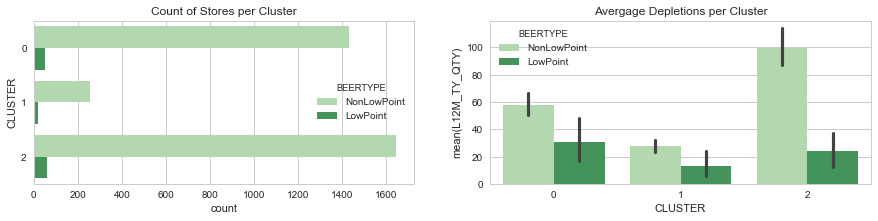

In [56]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "BEERTYPE", data=RegressionDataON, palette="Greens");

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="L12M_TY_QTY", hue="BEERTYPE", data=RegressionDataON, palette="Greens");

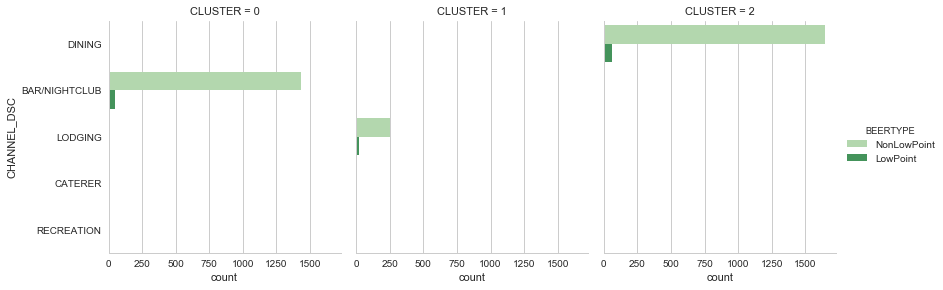

In [57]:
sns.factorplot(y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataON, kind="count", palette="Greens");

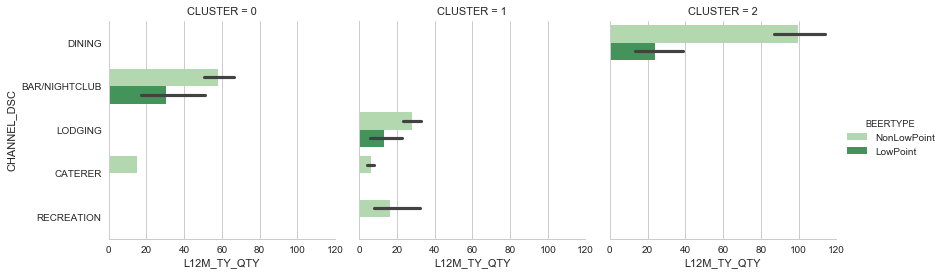

In [58]:
sns.factorplot(x='L12M_TY_QTY' ,y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataON, kind="bar", palette="Greens");

### Regression Based on Selected Cluster

#### Cluster 1

In [61]:
mod2ON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataON.loc[RegressionDataON["CLUSTER"]==1,:])
print(mod2ON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.064
Model:                             OLS   Adj. R-squared:                  0.061
Method:                  Least Squares   F-statistic:                     18.91
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           1.94e-05
Time:                         15:33:44   Log-Likelihood:                -423.98
No. Observations:                  277   AIC:                             852.0
Df Residuals:                      275   BIC:                             859.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [62]:
mod2ON = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataON.loc[RegressionDataON["CLUSTER"]==2,:])
print(mod2ON.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.019
Model:                             OLS   Adj. R-squared:                  0.019
Method:                  Least Squares   F-statistic:                     33.66
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           7.80e-09
Time:                         15:33:55   Log-Likelihood:                -3104.8
No. Observations:                 1707   AIC:                             6214.
Df Residuals:                     1705   BIC:                             6225.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

## OFF PREMISE ANALYSIS

### Data Preprocessing

##### Exploratory Analysis of the columns

In [63]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'PREMISE_TYPE_DSC', 'CHANNEL_DSC',
       'SUBCHANNEL_DSC', 'FOOD_TYPE_GROUP_DSC', 'INDUSTRY_VOL_DSC',
       'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'BEER_FLG', 'WINE_FLG', 'LIQUOR_FLG',
       'FINE_WINE_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [64]:
len(StoresOFF.columns)

43

In [65]:
for col in StoresOFF.columns:
    print(StoresOFF[col].describe())
    print()

count          1935
unique         1935
top       107266757
freq              1
Name: STORE_CD, dtype: object

count     1935.000000
mean       655.879266
std       1872.685344
min          1.000000
25%         34.000000
50%        146.000000
75%        626.958200
max      42742.964700
Name: L12M_TY_QTY, dtype: float64

count            1935
unique              1
top       OFF PREMISE
freq             1935
Name: PREMISE_TYPE_DSC, dtype: object

count       1935
unique         8
top       LIQUOR
freq        1076
Name: CHANNEL_DSC, dtype: object

count                    1935
unique                     14
top       CONVENTIONAL LIQUOR
freq                      973
Name: SUBCHANNEL_DSC, dtype: object

count      1935
unique        1
top       OTHER
freq       1935
Name: FOOD_TYPE_GROUP_DSC, dtype: object

count                              1935
unique                                3
top       LOWEST 20% ON/ LOWEST 20% OFF
freq                               1241
Name: INDUSTRY_VOL_DSC, dt

In [66]:
#Remove Not Necessary Columns
del StoresOFF['PREMISE_TYPE_DSC'] #Unique
del StoresOFF['FOOD_TYPE_GROUP_DSC'] #Unique
del StoresOFF['BEER_FLG'] # No Variance
del StoresOFF['FINE_WINE_FLG'] # No Variance


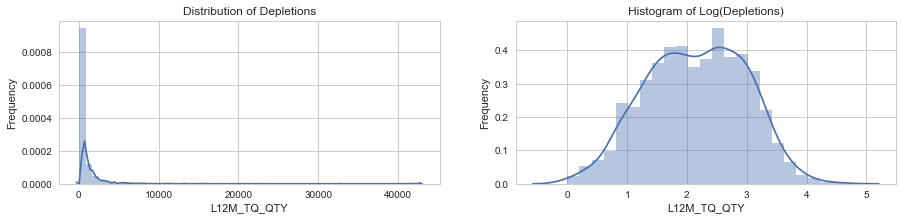

In [67]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,2)
plt.title('Histogram of Log(Depletions)')
sns.distplot(np.log10(StoresOFF['L12M_TY_QTY'].values))
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

plt.subplot(1,2,1)
plt.title('Distribution of Depletions')
sns.distplot(StoresOFF['L12M_TY_QTY'])
plt.xlabel('L12M_TQ_QTY')
plt.ylabel('Frequency')

In [68]:
StoresOFF.columns

Index(['STORE_CD', 'L12M_TY_QTY', 'CHANNEL_DSC', 'SUBCHANNEL_DSC',
       'INDUSTRY_VOL_DSC', 'CHAIN_IND_FLG', 'FRANCHISE_FLG', 'WINE_FLG',
       'LIQUOR_FLG', 'WHITE_POP_PCT', 'BLACK_POP_PCT', 'ASIAN_POP_PCT',
       'HISP_POP_PCT', 'LEAST_ACC_HISP_POP_PCT', 'BI_CULTURAL_HISP_POP_PCT',
       'MOST_ACC_HISP_POP_PCT', 'OTHER_POP_PCT', 'INCOME_POP_L10_PCT',
       'INCOME_POP_1020_PCT', 'INCOME_POP_2030_PCT', 'INCOME_POP_3040_PCT',
       'INCOME_POP_4050_PCT', 'INCOME_POP_5075_PCT', 'INCOME_POP_75100_PCT',
       'INCOME_POP_G100_PCT', 'MALE_POP_2124_PCT', 'MALE_POP_2534_PCT',
       'MALE_POP_3544_PCT', 'MALE_POP_4554_PCT', 'MALE_POP_5564_PCT',
       'MALE_POP_6574_PCT', 'MALE_POP_75_PCT', 'FEMALE_POP_2124_PCT',
       'FEMALE_POP_2534_PCT', 'FEMALE_POP_3544_PCT', 'FEMALE_POP_4554_PCT',
       'FEMALE_POP_5564_PCT', 'FEMALE_POP_6574_PCT', 'FEMALE_POP_75_PCT'],
      dtype='object')

In [69]:
#Get Dummies
DummiesColumnsOFF = ['CHANNEL_DSC','SUBCHANNEL_DSC','INDUSTRY_VOL_DSC']
StoresC_OFF = binarize(StoresOFF, DummiesColumnsOFF)

#Normalize Depletions using Min-Max method
scaler = MinMaxScaler() 
StoresC_OFF['NORM_L12M_TY_QTY'] = scaler.fit_transform(StoresOFF['L12M_TY_QTY'].values.reshape(-1,1)) 


In [70]:
# prepare data to fit model
X_labels_OFF = [c for c in StoresC_OFF.columns if c not in ['CHANNEL_DSC','SUBCHANNEL_DSC','INDUSTRY_VOL_DSC',
                                                     'STORE_CD','L12M_TY_QTY']]
X_OFF = StoresC_OFF.loc[:,X_labels_OFF]

In [71]:
X_OFF.head()

,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,BLACK_POP_PCT,ASIAN_POP_PCT,HISP_POP_PCT,LEAST_ACC_HISP_POP_PCT,BI_CULTURAL_HISP_POP_PCT,...,B_SUBCHANNEL_DSC_LIQUOR SUPER STORE,B_SUBCHANNEL_DSC_SUPERCENTER,B_SUBCHANNEL_DSC_SUPERETTE,B_SUBCHANNEL_DSC_SUPERMARKET-CONVENTIONAL,B_SUBCHANNEL_DSC_SUPERMARKET-NATURAL/GOURMET FOODS,B_SUBCHANNEL_DSC_WINE SPECIALTY STORE,B_INDUSTRY_VOL_DSC_LOWEST 20% ON/ LOWEST 20% OFF,B_INDUSTRY_VOL_DSC_MID 30% ON/ MID 60% OFF,B_INDUSTRY_VOL_DSC_TOP 50% ON/ TOP 20% OFF,NORM_L12M_TY_QTY
0,False,False,True,True,0.9268,0.0038,0.0168,0.0441,0.0098,0.0147,...,0,0,0,0,0,0,1,0,0,0.019863
1,True,False,False,False,0.8122,0.0801,0.0579,0.0300,0.0061,0.0107,...,0,0,0,1,0,0,1,0,0,0.002082
2,False,False,False,False,0.8396,0.0601,0.0472,0.0355,0.0080,0.0130,...,0,0,0,0,0,0,1,0,0,0.000608
3,False,False,True,True,0.9007,0.0271,0.0278,0.0300,0.0059,0.0099,...,0,0,0,0,0,0,0,0,1,0.005837
4,True,False,True,True,0.8278,0.0322,0.0889,0.0371,0.0073,0.0119,...,0,0,0,0,0,0,1,0,0,0.001199


### Clustering

#### Choose number of Clusters

In [74]:
#Silhouette_score
results = []
NumberClusters = range(2,12,1)
for k in NumberClusters:
    kmeans_model = cluster.KMeans(n_clusters=k, random_state=1, n_jobs = -2).fit(X_OFF)
    labels = kmeans_model.labels_
    score = metrics.silhouette_score(X_OFF, labels, metric='euclidean')
    results.append((k,score))

Clustering_Score = pd.DataFrame(data=results,columns=['NumberOfClusters','silhouette_score'])
Clustering_Score

,NumberOfClusters,silhouette_score
0,2,0.512460
1,3,0.543429
2,4,0.505324
3,5,0.579309
4,6,0.604331
5,7,0.578017
6,8,0.586038
7,9,0.602902
8,10,0.611753
9,11,0.617001


In [75]:
#Cluster the Data OFF
kmeans_model = cluster.KMeans(n_clusters=6, random_state=1, n_jobs = -2).fit(X_OFF)
labels = kmeans_model.labels_

In [76]:
#Assign Cluster to Data
StoresOFF['CLUSTER'] = labels

In [77]:
StoresOFF.head()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,...,MALE_POP_6574_PCT,MALE_POP_75_PCT,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER
0,101762688,849.9996,LIQUOR,CONVENTIONAL LIQUOR,LOWEST 20% ON/ LOWEST 20% OFF,False,False,True,True,0.9268,...,0.0402,0.0258,0.0287,0.0568,0.0611,0.0642,0.0635,0.0399,0.0336,4
1,100413001,90.0000,GROCERY,SUPERMARKET-CONVENTIONAL,LOWEST 20% ON/ LOWEST 20% OFF,True,False,False,False,0.8122,...,0.0423,0.0292,0.0186,0.0831,0.0677,0.0641,0.0732,0.0530,0.0454,1
2,100570775,27.0000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,LOWEST 20% ON/ LOWEST 20% OFF,False,False,False,False,0.8396,...,0.0391,0.0267,0.0157,0.0656,0.0751,0.0709,0.0733,0.0507,0.0475,2
3,100765405,250.5000,LIQUOR,CONVENTIONAL LIQUOR,TOP 50% ON/ TOP 20% OFF,False,False,True,True,0.9007,...,0.0359,0.0240,0.0553,0.0806,0.0568,0.0474,0.0551,0.0388,0.0375,5
4,102912880,52.2500,LIQUOR,CONVENTIONAL LIQUOR,LOWEST 20% ON/ LOWEST 20% OFF,True,False,True,True,0.8278,...,0.0403,0.0291,0.0225,0.0758,0.0663,0.0647,0.0698,0.0472,0.0434,4


### Regression Analysis

In [78]:
#Merge Class with StoreON Data for regression
RegressionDataOFF = pd.merge(StoresOFF, StoresClass, left_on='STORE_CD', right_on="RTL_STORE_CD", how="left")
RegressionDataOFF.loc[RegressionDataOFF['BEERTYPE'].isnull(),"BEERTYPE"] = "LowPoint"

In [79]:
RegressionDataOFF.tail()

,STORE_CD,L12M_TY_QTY,CHANNEL_DSC,SUBCHANNEL_DSC,INDUSTRY_VOL_DSC,CHAIN_IND_FLG,FRANCHISE_FLG,WINE_FLG,LIQUOR_FLG,WHITE_POP_PCT,...,FEMALE_POP_2124_PCT,FEMALE_POP_2534_PCT,FEMALE_POP_3544_PCT,FEMALE_POP_4554_PCT,FEMALE_POP_5564_PCT,FEMALE_POP_6574_PCT,FEMALE_POP_75_PCT,CLUSTER,RTL_STORE_CD,BEERTYPE
1930,100767421,915.4580,LIQUOR,CONVENTIONAL LIQUOR,LOWEST 20% ON/ LOWEST 20% OFF,False,False,True,True,0.8298,...,0.0189,0.0822,0.0624,0.0663,0.0811,0.0570,0.0471,4,100767421,NonLowPoint
1931,100078429,820.5000,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,LOWEST 20% ON/ LOWEST 20% OFF,False,False,False,False,0.6860,...,0.0171,0.0987,0.0861,0.0653,0.0546,0.0343,0.0160,2,NaN,LowPoint
1932,100503120,4207.8744,GROCERY,SUPERCENTER,MID 30% ON/ MID 60% OFF,True,False,False,False,0.8729,...,0.0238,0.0538,0.0578,0.0657,0.0701,0.0483,0.0377,1,100503120,NonLowPoint
1933,101406833,164.0000,LIQUOR,CONVENTIONAL LIQUOR,MID 30% ON/ MID 60% OFF,False,False,True,True,0.9286,...,0.0205,0.0470,0.0516,0.0630,0.0769,0.0684,0.0479,0,101406833,NonLowPoint
1934,101955809,1279.3332,LIQUOR,CONVENTIONAL LIQUOR,LOWEST 20% ON/ LOWEST 20% OFF,True,False,True,True,0.9700,...,0.0246,0.0639,0.0560,0.0711,0.0735,0.0482,0.0255,4,101955809,NonLowPoint


In [80]:
len(RegressionDataOFF)

1935

### Regression controlling for Cluster

In [81]:
#Regression ON Premise
modOFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE) + C(CLUSTER)', data=RegressionDataOFF)
print(modOFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.330
Model:                             OLS   Adj. R-squared:                  0.328
Method:                  Least Squares   F-statistic:                     158.0
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):          1.72e-163
Time:                         15:38:13   Log-Likelihood:                -3603.1
No. Observations:                 1935   AIC:                             7220.
Df Residuals:                     1928   BIC:                             7259.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

### Analysis of the Clusters

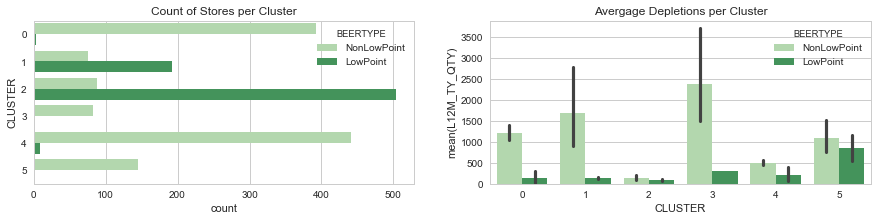

In [82]:
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title("Count of Stores per Cluster")
sns.countplot(y="CLUSTER", hue= "BEERTYPE", data=RegressionDataOFF, palette="Greens");

plt.subplot(1,2,2)
plt.title("Avergage Depletions per Cluster")
sns.barplot(x="CLUSTER", y="L12M_TY_QTY", hue="BEERTYPE", data=RegressionDataOFF, palette="Greens");

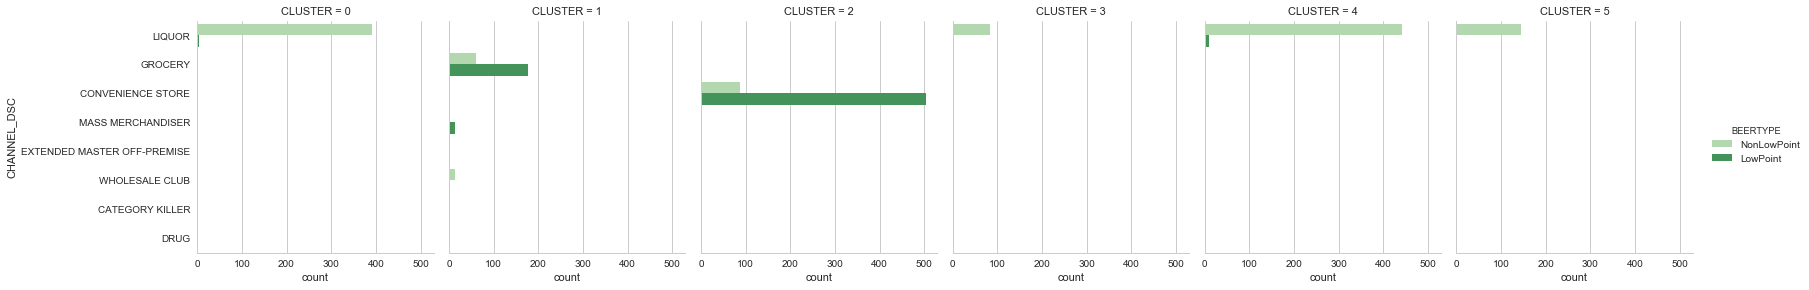

In [83]:
sns.factorplot(y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataOFF, kind="count", palette="Greens");

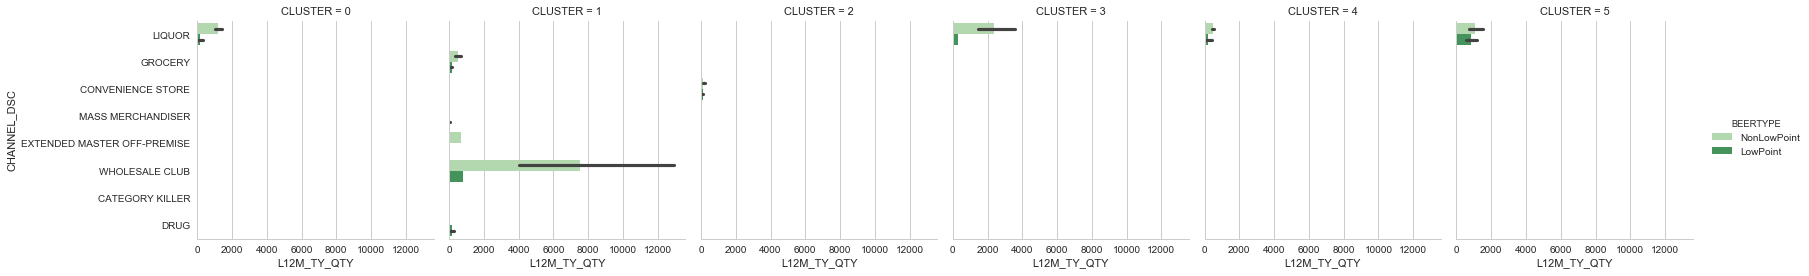

In [84]:
sns.factorplot(x='L12M_TY_QTY' ,y="CHANNEL_DSC", hue="BEERTYPE",
               col="CLUSTER", data=RegressionDataOFF, kind="bar", palette="Greens");

### Regression Based on Selected Cluster

#### Cluster 1

In [85]:
mod2OFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF.loc[RegressionDataOFF["CLUSTER"]==1,:])
print(mod2OFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.175
Model:                             OLS   Adj. R-squared:                  0.172
Method:                  Least Squares   F-statistic:                     56.25
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):           9.66e-13
Time:                         15:40:12   Log-Likelihood:                -494.30
No. Observations:                  267   AIC:                             992.6
Df Residuals:                      265   BIC:                             999.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [86]:
mod2OFF = smf.ols(formula='np.log(L12M_TY_QTY) ~ C(BEERTYPE)', data=RegressionDataOFF.loc[RegressionDataOFF["CLUSTER"]==2,:])
print(mod2OFF.fit().summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(L12M_TY_QTY)   R-squared:                       0.004
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     2.576
Date:                 Thu, 29 Jun 2017   Prob (F-statistic):              0.109
Time:                         15:40:22   Log-Likelihood:                -1048.2
No. Observations:                  592   AIC:                             2100.
Df Residuals:                      590   BIC:                             2109.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 